# RTSM Project

In [1]:
import numpy as np
from scipy.stats import t, chi2,f
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import genfromtxt
from sklearn.preprocessing import PolynomialFeatures
import cvxpy as cp
import random
import math
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split

# Dataset Loading and EDA


In [2]:
df = pd.read_csv('Concrete_Data.csv')

In [3]:
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
df.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.166408,73.894854,54.187379,181.564854,6.203204,972.918932,773.579515,45.662136,35.817961
std,104.507710,86.279340,63.995962,21.355663,5.973035,77.753954,80.175801,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.300000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


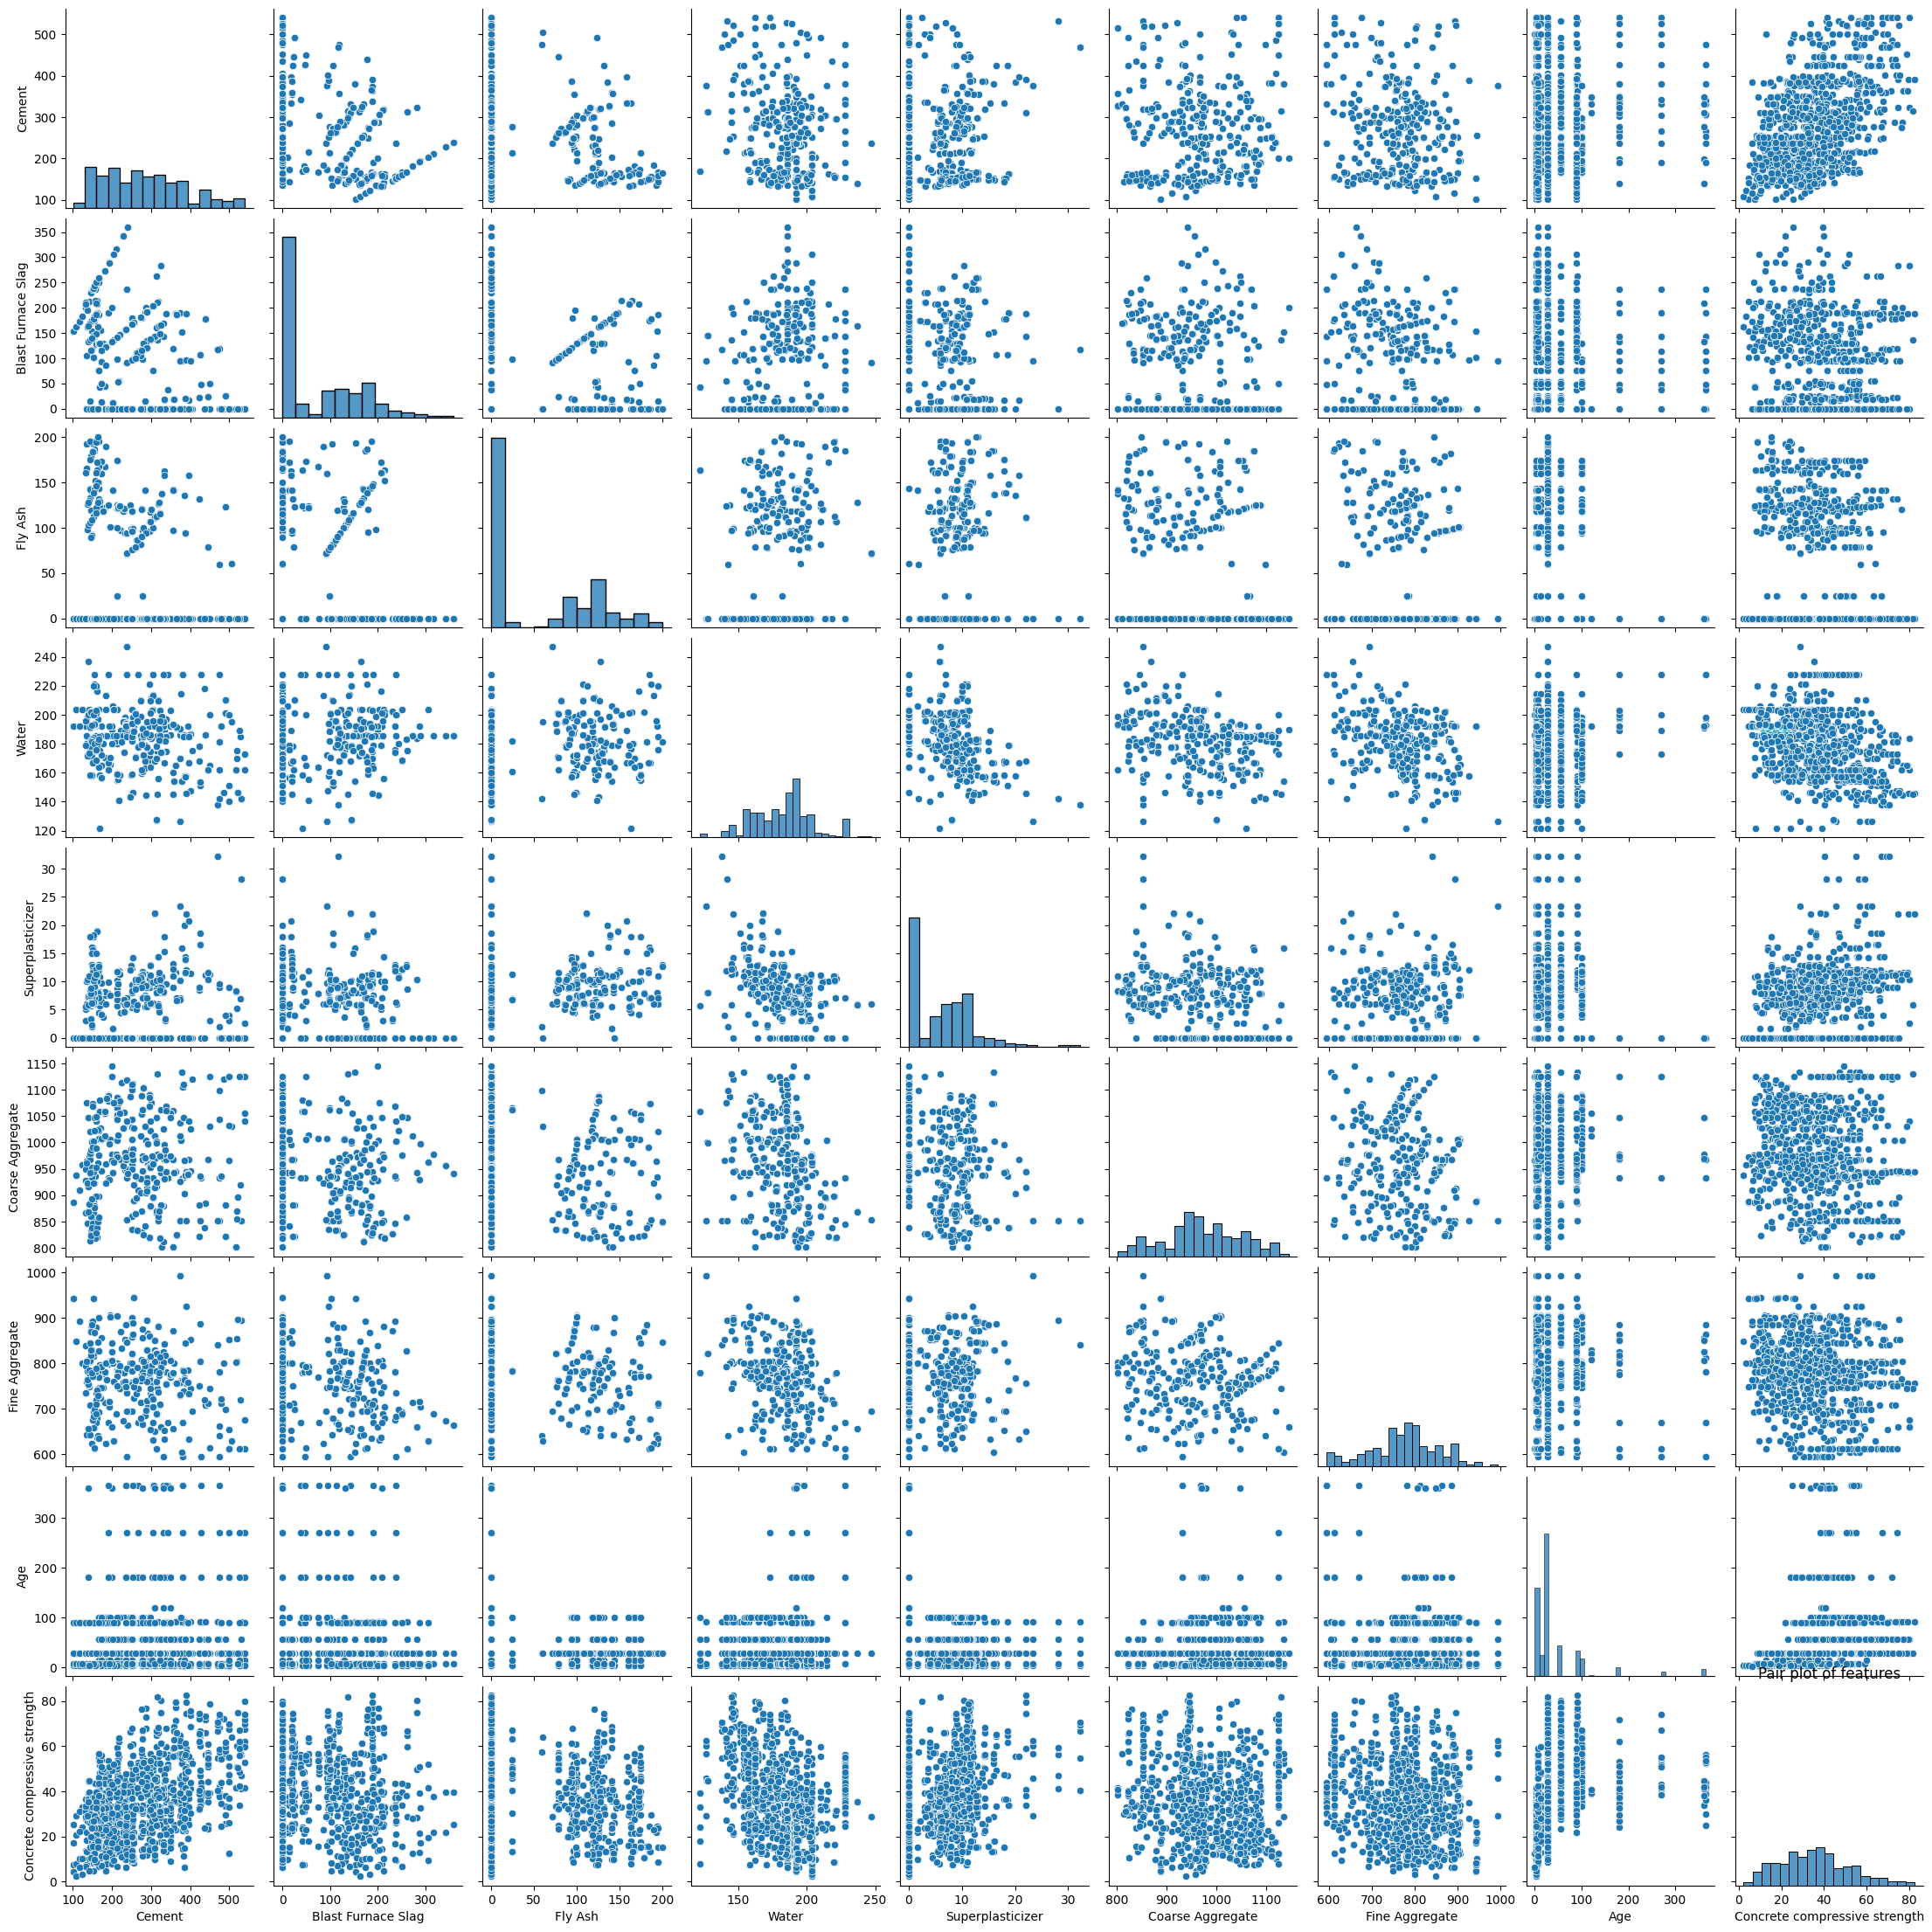

In [5]:
sns.pairplot(df)
plt.title('Pair plot of features')
plt.show()

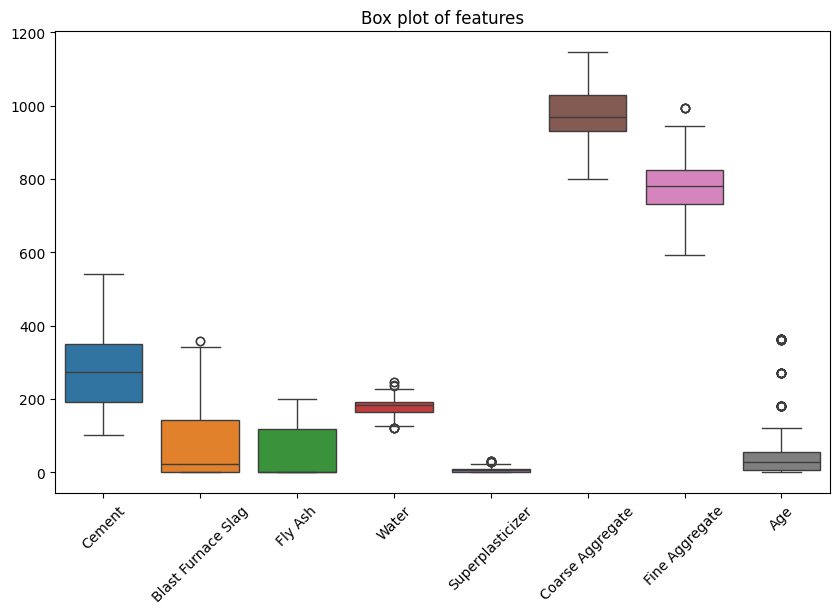

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.drop('Concrete compressive strength', axis=1))
plt.title('Box plot of features')
plt.xticks(rotation=45)
plt.show()

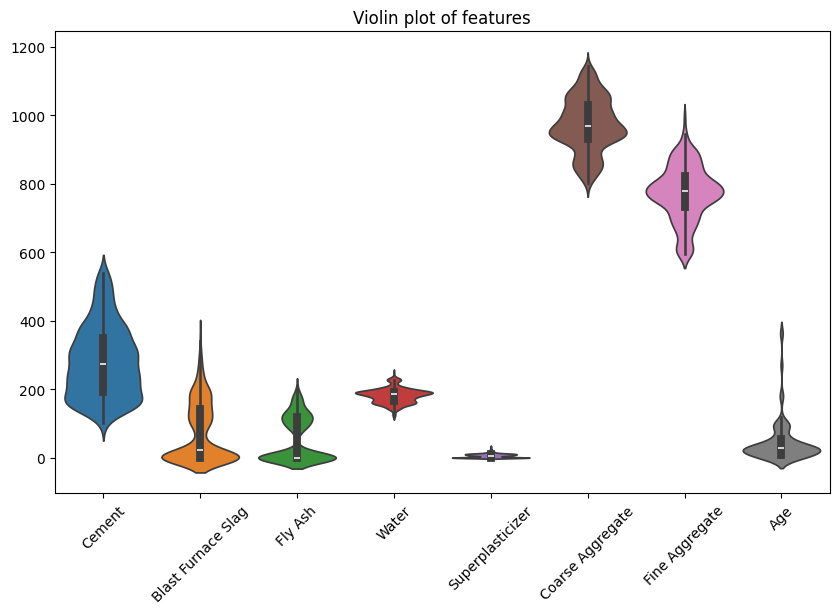

In [7]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df.drop('Concrete compressive strength', axis=1))
plt.title('Violin plot of features')
plt.xticks(rotation=45)
plt.show()

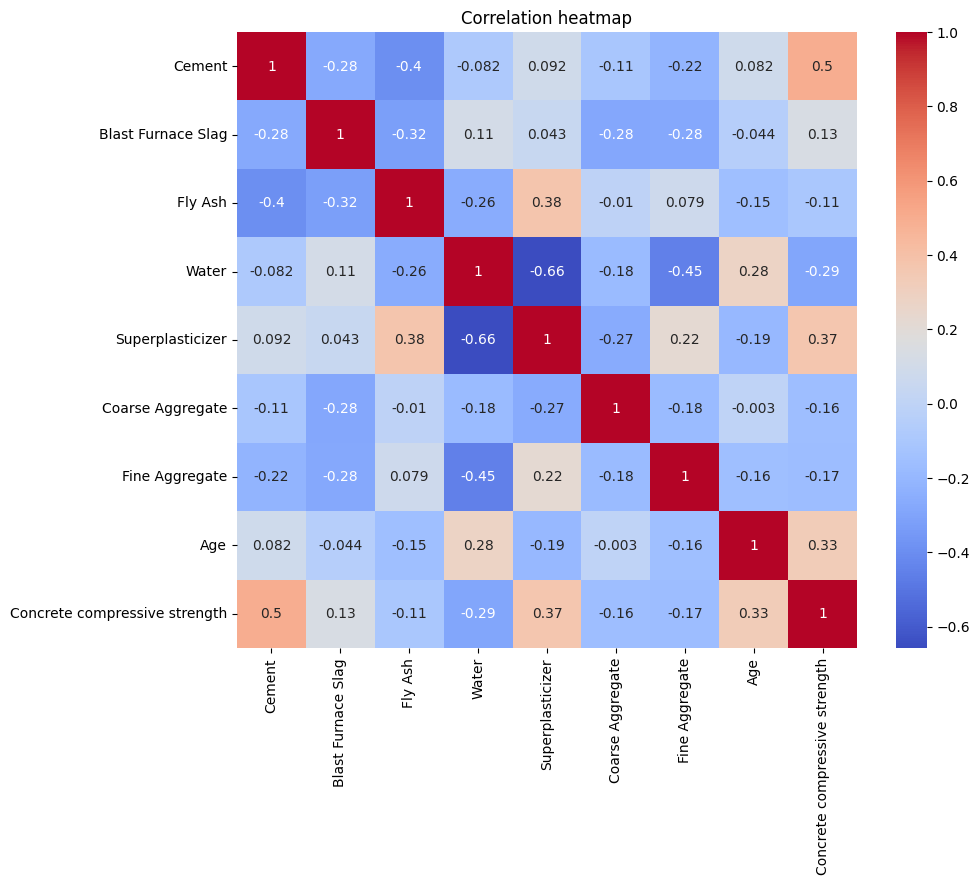

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

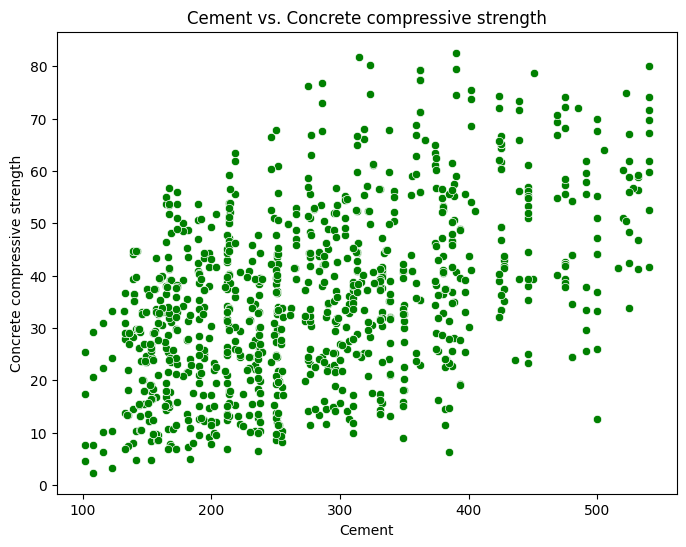

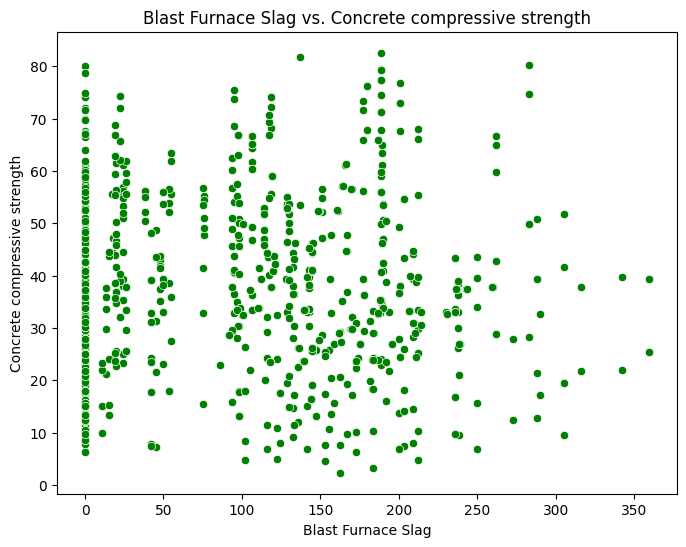

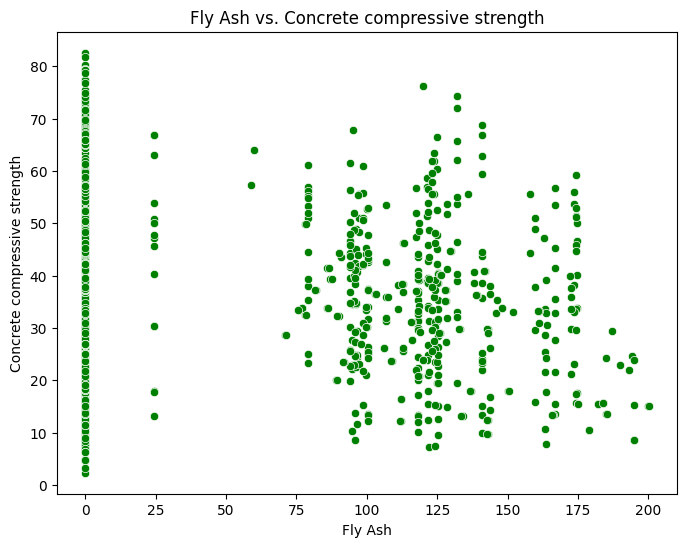

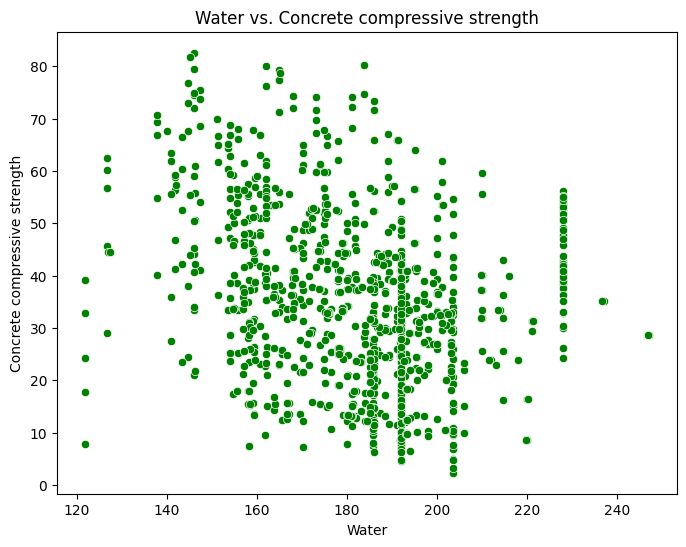

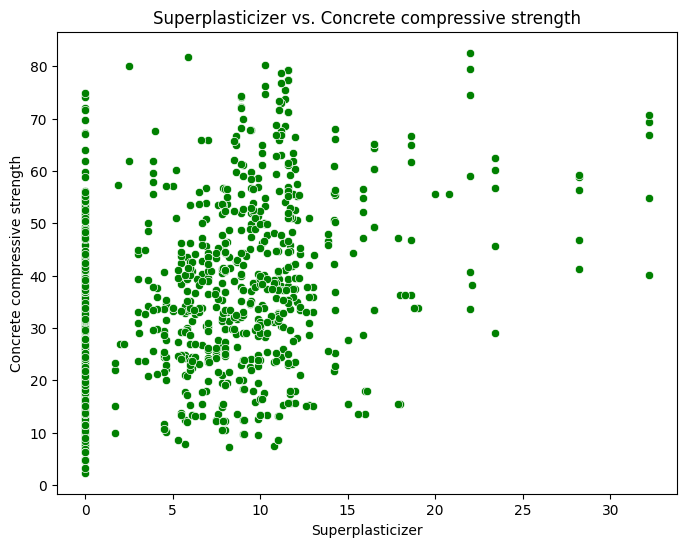

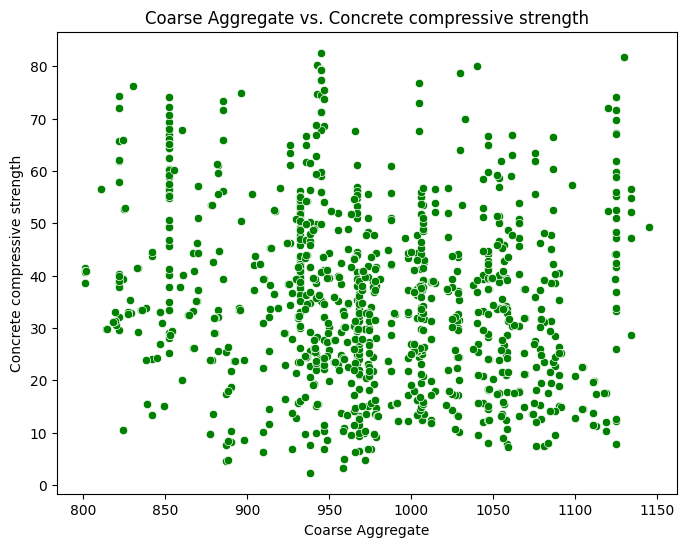

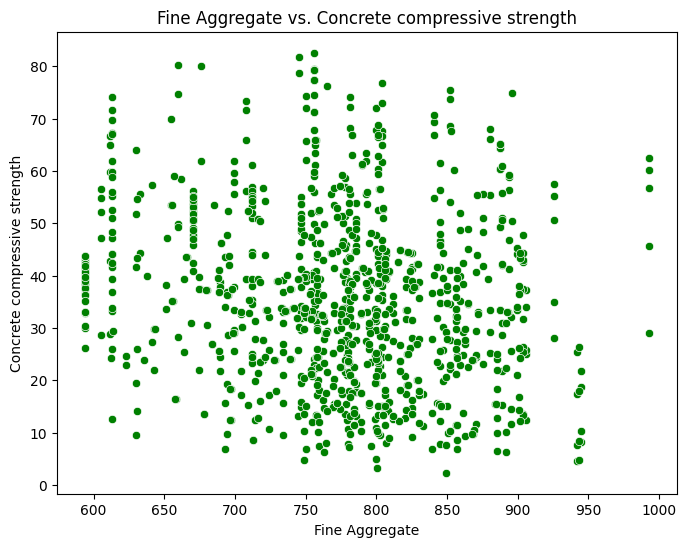

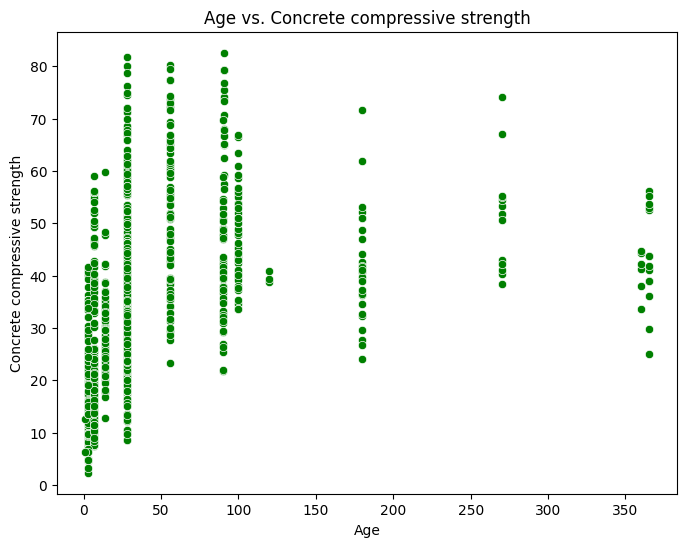

In [9]:
for column in df.columns:
    if column != 'Concrete compressive strength':
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x=column, y='Concrete compressive strength', color='green')
        plt.title(f'{column} vs. Concrete compressive strength')
        plt.xlabel(column)
        plt.ylabel('Concrete compressive strength')
        plt.show()

# Multiple Regression


In [10]:
import numpy as np
from scipy.stats import t, chi2, f

def fit(X, Y):
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y
    return beta

def analyse_model(X, Y, beta, X_test = None, Y_test = None,print_terms=False,test_check = True):
    k = X.shape[1] - 1
    n = Y.shape[0]

    Y_est = X @ beta
    e = Y - Y_est
    sigma_square_est = (e.T @ e) / (n - k - 1)

    significance = []

    # Testing significance of coefficients
    C = np.linalg.inv(X.T @ X)
    alpha = 0.05
    test_stat_beta = np.zeros(k + 1)

    for i in range(k + 1):
        test_stat_beta[i] = beta[i] / (np.sqrt(sigma_square_est) * np.sqrt(C[i, i]))

    significant_count = 0
    non_significant_count = 0
    for i in range(k + 1):
        if np.abs(test_stat_beta[i]) > t.ppf(1 - alpha / 2, n - k - 1, loc=0, scale=1):
            significance.append(1)
            significant_count += 1
            if print_terms:
              print("beta", i, " is significant")
        else:
            significance.append(0)
            non_significant_count += 1
            if print_terms:
              print("beta", i, " is not significant")

    # Confidence intervals
    l_interval_beta = np.zeros(k + 1)
    h_interval_beta = np.zeros(k + 1)

    for i in range(k + 1):
        l_interval_beta[i] = beta[i] - np.sqrt(sigma_square_est) * t.ppf(1 - alpha / 2, n - k - 1, loc=0, scale=1) * np.sqrt(C[i, i])
        h_interval_beta[i] = beta[i] + np.sqrt(sigma_square_est) * t.ppf(1 - alpha / 2, n - k - 1, loc=0, scale=1) * np.sqrt(C[i, i])
        if print_terms:
          print("95% confidence interval for beta", i, ":", l_interval_beta[i], ",", h_interval_beta[i])

    l_interval_sigma_square = (n - k - 1) * sigma_square_est / chi2.ppf(1 - alpha / 2, df=n - k - 1)
    h_interval_sigma_square = (n - k - 1) * sigma_square_est / chi2.ppf(alpha / 2, df=n - k - 1)
    if print_terms:
      print("95% confidence interval for sigma square :", l_interval_sigma_square, ",", h_interval_sigma_square)

    # ANOVA + coefficient of determination
    SSError = e.T @ e
    SSTotal = (Y - np.mean(Y)).T @ (Y - np.mean(Y))
    SSReg = SSTotal - SSError
    test_stat_anova = (SSReg * (n - k - 1)) / (SSError * k)

    if ((test_stat_anova < f.ppf(1 - alpha / 2, dfn=k, dfd=n - k - 1, loc=0, scale=1)) and (
            test_stat_anova > f.ppf(alpha / 2, dfn=k, dfd=n - k - 1, loc=0, scale=1))) or non_significant_count==n:
        model_significance = "insignificant"
    else:
        model_significance = "significant"

    print("The Sum of Sqaured Errors for the model ( SSE ) :",SSError)
    print("The Mean Squared error for the model ( MSE ) :",SSError/(n-1))
    print("The Sum of Squares Regression for the model ( SSR ) :",SSReg)
    print("The Total error for the model ( SST ) : ",SSTotal)
    print("The Model is ",model_significance)

    R_2 = 1 - (SSError / SSTotal)
    R_2_adjusted = 1 - (SSError / SSTotal) * ((n - 1) / (n - k - 1))

    # Printing results
    print("Multiple Regression Model Summary:")
    print("-----------------------------------------")
    print("R-squared            : {:.4f}".format(R_2))
    print("Adjusted R-squared   : {:.4f}".format(R_2_adjusted))
    print("Number of significant terms   : {}".format(significant_count))
    print("Number of non-significant terms: {}".format(non_significant_count))
    print("Model significance   : {}".format(model_significance))

    if test_check:
      # Test set
      Y_test_pred= X_test @ beta
      SSE = np.sum((Y_test_pred - Y_test)**2)
      print("SSE on test set:",SSE)
      print("MSE on test set:",SSE/X_test.shape[1])

    print("-----------------------------------------")


    return R_2, R_2_adjusted,significance



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

def plot_residual(X, Y, beta, k):
    error = Y - X @ beta
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    MSError = error.T @ error / (X.shape[0] - k - 1)
    d = error / np.sqrt(MSError)
    r = np.array([error[i] / np.sqrt(MSError * (1 - H[i, i])) for i in range(Y.shape[0])])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Scatter plot of Y vs. r
    ax1.scatter(X@beta, r, color='blue', alpha=0.5)
    ax1.set_xlabel('Y (predicted)')
    ax1.set_ylabel('Studentized Residuals (r)')
    ax1.set_title('Residual Plot')
    ax1.grid(True)

    # Histogram of studentized residuals
    ax2.hist(r, bins=20, density=True, alpha=0.6, color='green')
    ax2.set_xlabel('Studentized Residuals (r)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Histogram of Studentized Residuals')
    ax2.grid(True)

    # Calculate chi-square statistic and p-value
    observed_counts, _ = np.histogram(r, bins=20, density=True)
    expected_counts = np.mean(observed_counts) * np.ones_like(observed_counts)
    chi2_statistic = np.sum((observed_counts - expected_counts) ** 2 / expected_counts)

    # Calculate degrees of freedom
    df = len(observed_counts) - 1

    # Calculate p-value
    p_value = chi2.sf(chi2_statistic, df)

    # Print chi-square test result
    print("Chi-square statistic:", chi2_statistic)
    print("P-value:", p_value)

    plt.tight_layout()
    plt.show()


# Fitting data

In [12]:
X_data = np.array(df.drop(['Concrete compressive strength'],axis = 1))

Y_data = np.array(df['Concrete compressive strength'])

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

# Scale labels (Y_data)
scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(Y_data.reshape(-1, 1)).reshape(-1)

X = X_scaled.copy()
Y = Y_scaled.copy()
n = np.size(Y)
X = np.concatenate((np.ones((n,1)),X),axis=1)

The value of beta0 is -0.00022021634322658828
The value of beta1 is 0.7443133159110672
The value of beta2 is 0.5604716950282813
The value of beta3 is 0.31472507060666927
The value of beta4 is -0.17335909258652094
The value of beta5 is 0.11063442201274962
The value of beta6 is 0.0829256551997025
The value of beta7 is 0.11548187137899125
The value of beta8 is 0.4403094364220793
beta 0  is not significant
beta 1  is significant
beta 2  is significant
beta 3  is significant
beta 4  is significant
beta 5  is significant
beta 6  is not significant
beta 7  is significant
beta 8  is significant
95% confidence interval for beta 0 : -0.043574477891147524 , 0.04313404520469435
95% confidence interval for beta 1 : 0.6290990502749305 , 0.8595275815472039
95% confidence interval for beta 2 : 0.44572749558127067 , 0.675215894475292
95% confidence interval for beta 3 : 0.20836671556076408 , 0.42108342565257445
95% confidence interval for beta 4 : -0.28409053769322345 , -0.06262764747981844
95% confide

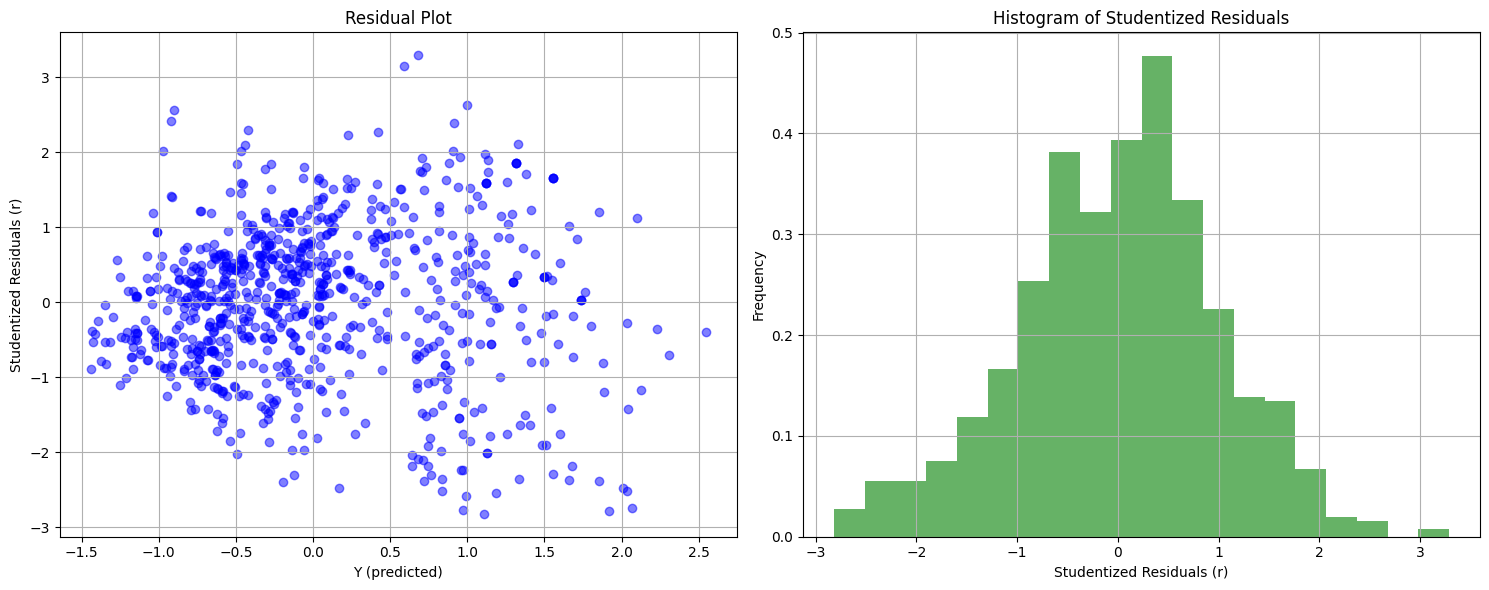

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
beta = fit(X_train,Y_train)
for i in range(X.shape[1]):
  print(f"The value of beta{i} is {beta[i]}")

analyse_model(X_train,Y_train,beta,X_test, Y_test,True)
plot_residual(X_train, Y_train, beta, X.shape[1]-1)

# Polynomial regression (Naive)

In [14]:
def multicollinearity_remover(degree,max_corr,X):
    k=np.shape(X)[1] - 1
    c=[]
    for i in range(k+1):
        c.append(i)
    terms=[]
    for x in itertools.combinations_with_replacement(c, degree):
        terms.append(x)
    new_X=np.zeros((np.shape(X)[0],1))
    for j in range(len(terms)):
        e=np.ones((np.shape(X)[0],1))
        for i in terms[j]:
            t=t1=np.reshape(X[:,i],np.shape(e))
            e=np.multiply(e,t)
        new_X=np.concatenate((new_X,e),axis=1)
    new_X=new_X[:,1:]
    t=pd.DataFrame(new_X[:,1:])
    corr_matrix=np.array(t.corr())
    indices_list = []
    adjunct_terms=[]

    # Iterate through the correlation matrix and store indices with value greater than max_corr
    for i in range(corr_matrix.shape[0]):
        for j in range(i + 1, corr_matrix.shape[1]):  # Only iterate over upper triangle
            if abs(corr_matrix[i, j]) > max_corr:
                indices_list.append((i, j))


    for i,j in indices_list:
        adjunct_terms.append(terms[j+1])

    utilizable_terms = []
    for element in terms:
        if element not in adjunct_terms:
            utilizable_terms.append(element)
    new_X=np.zeros((np.shape(X)[0],1))
    for j in range(len(utilizable_terms)):
        e=np.ones((np.shape(X)[0],1))
        for i in utilizable_terms[j]:
            t=t1=np.reshape(X[:,i],np.shape(e))
            e=np.multiply(e,t)
        new_X=np.concatenate((new_X,e),axis=1)
    new_X=new_X[:,1:]
    return (new_X,utilizable_terms)

In [15]:
def fit_upto_degree(X,Y,degree, test_split = 0.2):
  X = np.array(X)
  Y = np.array(Y)
  n = np.size(Y)

  X_modified,usable_terms = multicollinearity_remover(degree,0.98,X)
  k = np.shape(X_modified)[1] - 1

  X_train, X_test, Y_train, Y_test = train_test_split(X_modified, Y, test_size=0.2, random_state=42)
  beta = fit(X_train,Y_train)

  R2, R2_adj,significance = analyse_model(X_train,Y_train,beta, X_test,Y_test)
  high_deg_sig=0
  for i in range(k+1):
    if ((0  not in usable_terms[i]) and (significance[i]==1)):
      high_deg_sig=1
      break
  plot_residual(X_modified, Y, beta, X_modified.shape[1]-1)
  return R2, R2_adj,high_deg_sig


Degree 1 polynomial regression started
The Sum of Sqaured Errors for the model ( SSE ) : 327.0238269666074
The Mean Squared error for the model ( MSE ) : 0.3973558043336663
The Sum of Squares Regression for the model ( SSR ) : 512.5675209674787
The Total error for the model ( SST ) :  839.5913479340861
The Model is  significant
Multiple Regression Model Summary:
-----------------------------------------
R-squared            : 0.6105
Adjusted R-squared   : 0.6067
Number of significant terms   : 7
Number of non-significant terms: 2
Model significance   : significant
SSE on test set: 70.89839076776099
MSE on test set: 7.877598974195665
-----------------------------------------
Chi-square statistic: 2.6207568842880433
P-value: 0.9999964600144139


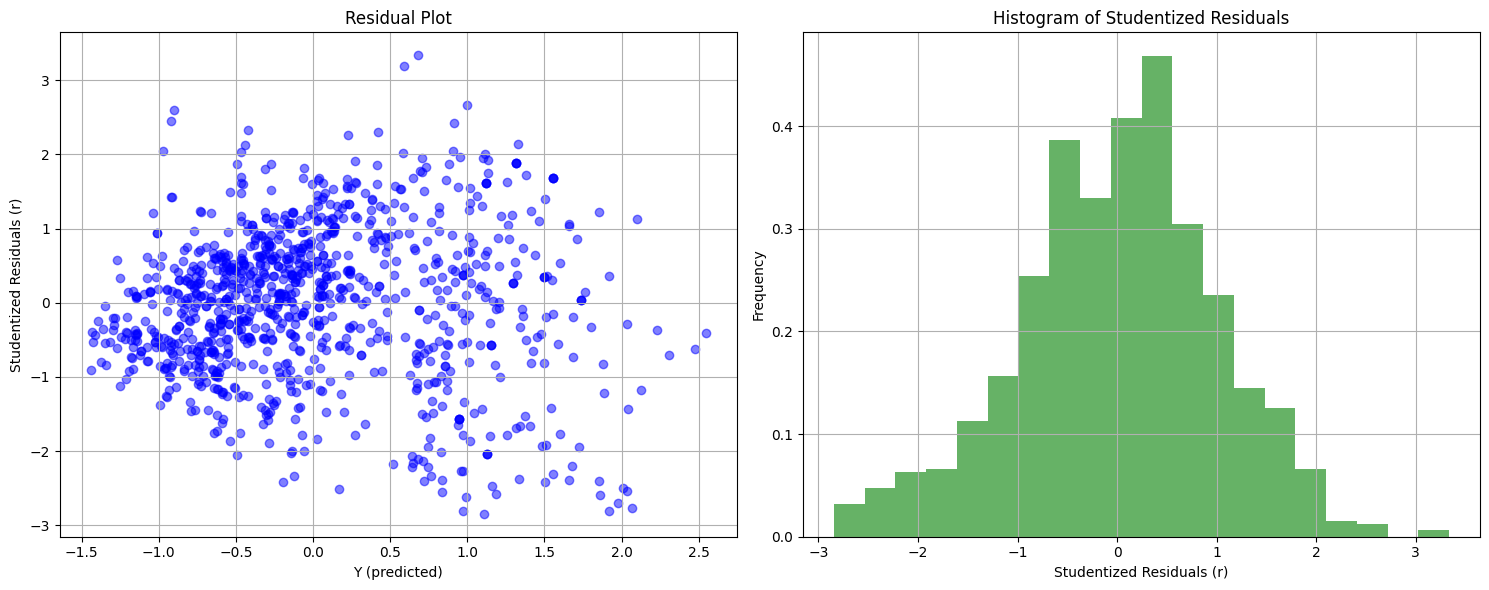

continue forward selection


Degree 2 polynomial regression started
The Sum of Sqaured Errors for the model ( SSE ) : 156.9317787003946
The Mean Squared error for the model ( MSE ) : 0.19068259866390597
The Sum of Squares Regression for the model ( SSR ) : 682.6595692336915
The Total error for the model ( SST ) :  839.5913479340861
The Model is  significant
Multiple Regression Model Summary:
-----------------------------------------
R-squared            : 0.8131
Adjusted R-squared   : 0.8025
Number of significant terms   : 29
Number of non-significant terms: 16
Model significance   : significant
SSE on test set: 41.07728215659739
MSE on test set: 0.9128284923688309
-----------------------------------------
Chi-square statistic: 3.1198816790193296
P-value: 0.9999851583932261


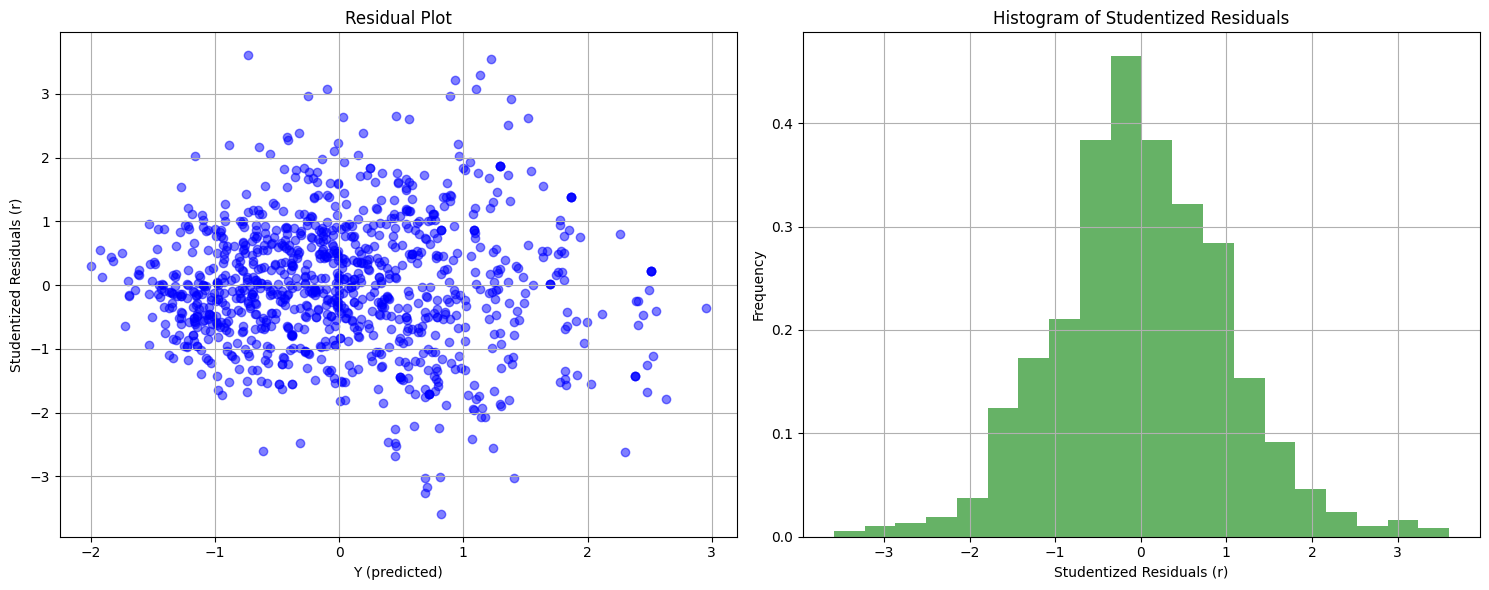

continue forward selection


Degree 3 polynomial regression started
The Sum of Sqaured Errors for the model ( SSE ) : 78.17014791859738
The Mean Squared error for the model ( MSE ) : 0.09498195372855088
The Sum of Squares Regression for the model ( SSR ) : 761.4212000154887
The Total error for the model ( SST ) :  839.5913479340861
The Model is  significant
Multiple Regression Model Summary:
-----------------------------------------
R-squared            : 0.9069
Adjusted R-squared   : 0.8843
Number of significant terms   : 32
Number of non-significant terms: 130
Model significance   : significant
SSE on test set: 41.83715282127673
MSE on test set: 0.25825402976096745
-----------------------------------------
Chi-square statistic: 4.914237738640554
P-value: 0.9994985823460552


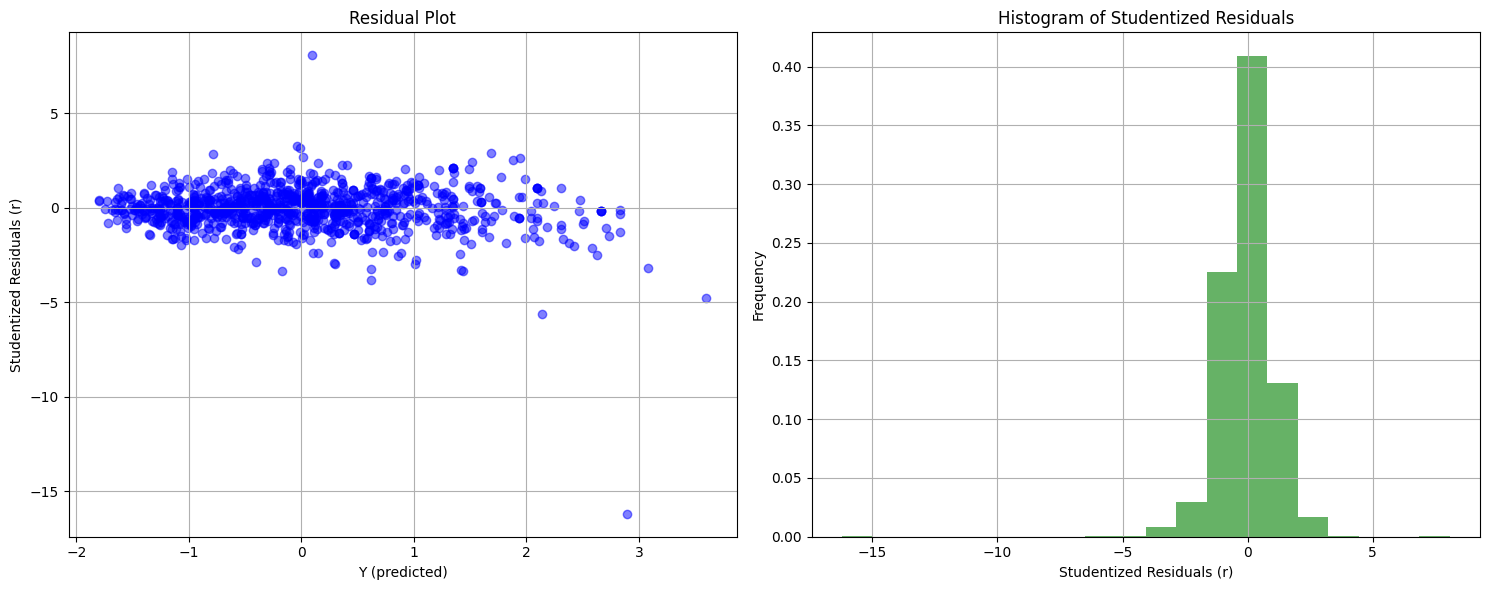

continue forward selection


Degree 4 polynomial regression started
The Sum of Sqaured Errors for the model ( SSE ) : 29.958622085983695
The Mean Squared error for the model ( MSE ) : 0.036401727929506314
The Sum of Squares Regression for the model ( SSR ) : 809.6327258481024
The Total error for the model ( SST ) :  839.5913479340861
The Model is  significant
Multiple Regression Model Summary:
-----------------------------------------
R-squared            : 0.9643
Adjusted R-squared   : 0.9173
Number of significant terms   : 26
Number of non-significant terms: 443
Model significance   : significant
SSE on test set: 1426.7819397618653
MSE on test set: 3.0421789760380924
-----------------------------------------
Chi-square statistic: 0.19699256247957228
P-value: 0.9999999999999998


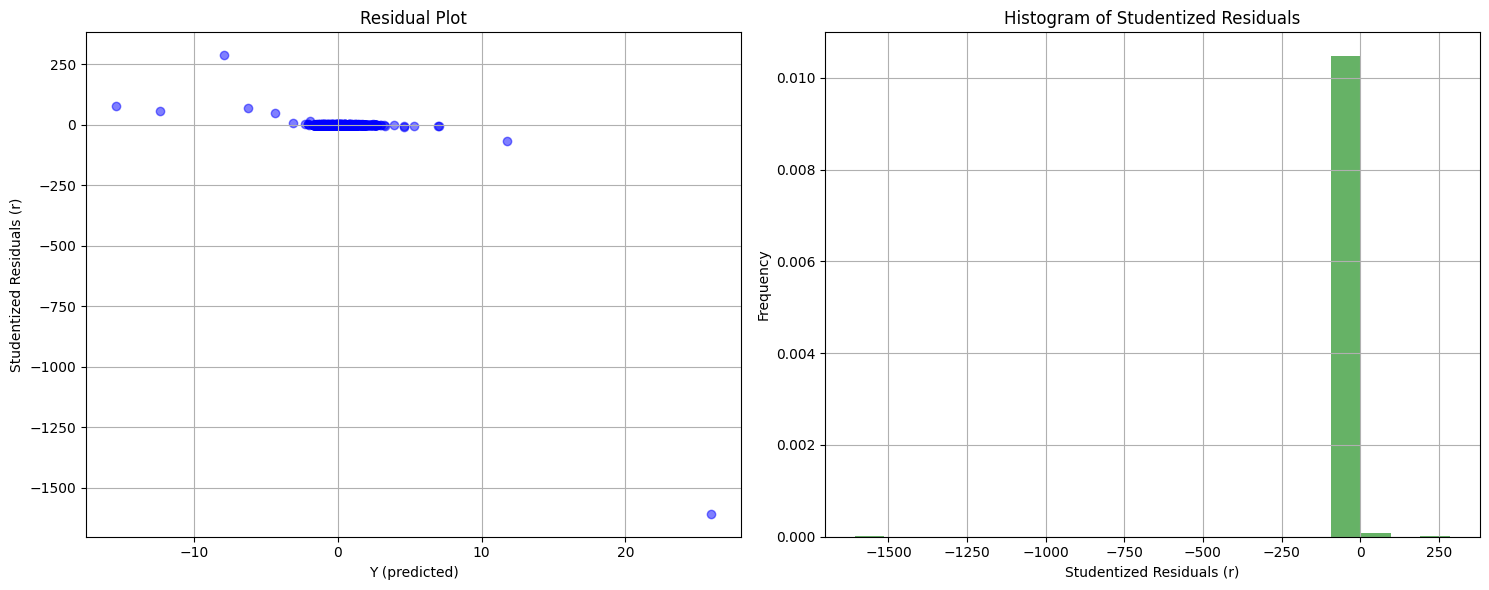

continue forward selection




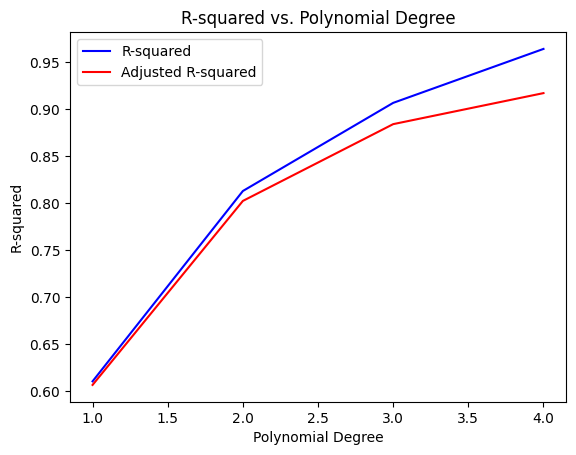

In [16]:
max_degree = 4

R2 = []
R2_adj = []
stop_flag=0

for d in range(1, max_degree + 1):
    print(f"Degree {d} polynomial regression started")
    x, y,high_deg_sig = fit_upto_degree(X, Y, d)
    if(stop_flag==0):
      if(high_deg_sig==0):
        print("stop at degree",d-1)
        stop_flag=1
      else:
        print("continue forward selection")
    if stop_flag:
      break
    R2.append(x)
    R2_adj.append(y)
    print("\n")

import matplotlib.pyplot as plt
plt.plot([d for d in range(1, len(R2)+1)], R2, label='R-squared', color='blue')
plt.plot([d for d in range(1, len(R2)+1)], R2_adj, label='Adjusted R-squared', color='red')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.title('R-squared vs. Polynomial Degree')
plt.legend()
plt.show()

# Principal Component Regression

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def gram_schmidt(vectors):
    num_vectors = vectors.shape[1]
    basis = np.zeros_like(vectors)
    basis[:,0] = vectors[:,0]
    for i in range(num_vectors):
        basis[:, i] = vectors[:, i]
        for j in range(i):
            basis[:, i] -= np.dot(basis[:, j], vectors[:, i]) / np.dot(basis[:, j], basis[:, j]) * basis[:, j]
        basis[:, i] /= np.linalg.norm(basis[:, i])
    return basis

def pcr(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    cov_mat = X_train.T @ X_train
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    eig_pairs = [(eig_vals[i], eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    eig_vals_sorted = np.array([X_train[0] for X_train in eig_pairs])
    eig_vecs_sorted = np.array([X_train[1] for X_train in eig_pairs]).T
    p = gram_schmidt(eig_vecs_sorted)
    error = np.linalg.norm(cov_mat - p @ np.diag(eig_vals_sorted) @ p.T)
    if error > 1e-6:
        print("PCR failed: Reconstruction error too large")
        return -1

    total_variance = sum(eig_vals)
    t = 0
    cumulative_sum = 0.0
    for eigenvalue, _ in eig_pairs:
        cumulative_sum += eigenvalue
        t += 1
        if t>= 200:
            break

    selected_eig_pairs = eig_pairs[:t]
    selected_eigenvalues = [pair[0] for pair in selected_eig_pairs]
    selected_eigenvectors = p[:, :t]
    z = X_train @ selected_eigenvectors
    alpha = np.linalg.inv(z.T @ z) @ z.T @ Y_train
    num_features = X_train.shape[1]
    alpha_padded = np.pad(alpha, (0, num_features - len(alpha)), mode='constant')
    coefficients_beta = p @ alpha_padded
    Y_train_pred = X_train @ coefficients_beta
    SST = np.sum((Y_train - np.mean(Y_train))**2)
    SSE = np.sum((Y_train - Y_train_pred)**2)
    R_squared = 1 - (SSE / SST)
    n = X_train.shape[0]
    p = X_train.shape[1] - 1
    R_squared_adj = 1 - (1 - R_squared) * ((n - 1) / (n - p - 1))

    Y_test_pred= X_test @ coefficients_beta
    SSE_test = np.sum((Y_test_pred - Y_test)**2)

    print("Mean Squared Error:", SSE/X_train.shape[0])
    print("Sum of Squared Errors (SSE):", SSE)
    print("Total Sum of Squares (SST):", SST)
    print("R-squared (R2):", R_squared)
    print("Adjusted R-squared (R2_adjusted):", R_squared_adj)
    print("SSE on test set:",SSE_test)
    print("MSE on test set:",SSE_test/X_test.shape[0])

    return  R_squared, R_squared_adj


In [18]:
def fit_upto_degree_pcr(X, Y, degree):
    X = np.array(X)
    Y = np.array(Y)
    poly = PolynomialFeatures(degree)
    new_X = poly.fit_transform(X)
    result = pcr(new_X, Y)
    return result


Degree 1 PCR started
Mean Squared Error: 0.3968735764157856
Sum of Squared Errors (SSE): 327.0238269666073
Total Sum of Squares (SST): 839.5913479340861
R-squared (R2): 0.610496430470266
Adjusted R-squared (R2_adjusted): 0.6066730825485018
SSE on test set: 70.89839076776096
MSE on test set: 0.3441669454745678


Degree 2 PCR started
Mean Squared Error: 0.19045118774319733
Sum of Squared Errors (SSE): 156.9317787003946
Total Sum of Squares (SST): 839.5913479340861
R-squared (R2): 0.8130855217999282
Adjusted R-squared (R2_adjusted): 0.8025280929927354
SSE on test set: 41.07728215659646
MSE on test set: 0.19940428231357504


Degree 3 PCR started
Mean Squared Error: 0.07024401379574416
Sum of Squared Errors (SSE): 57.88106736769319
Total Sum of Squares (SST): 839.5913479340861
R-squared (R2): 0.9310604289692641
Adjusted R-squared (R2_adjusted): 0.9139039955109323
SSE on test set: 29.7723006430607
MSE on test set: 0.1445257312769937


Degree 4 PCR started
Mean Squared Error: 0.07101037811142

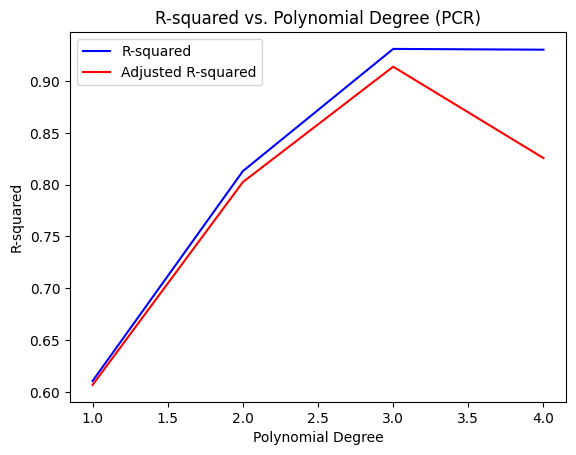

In [19]:
max_degree = 4
R2 = []
R2_adj = []
ok = True
X = X_scaled.copy()
for d in range(1, max_degree + 1):
    print(f"Degree {d} PCR started")
    result = fit_upto_degree_pcr(X, Y, d)  # Assuming you have a function fit_upto_degree_pcr to fit the PCR model
    if result == -1:
        ok = False
        break
    R2.append(result[0])
    R2_adj.append(result[1])
    print("\n")

if ok:
    plt.plot(np.array([d for d in range(1, max_degree + 1)]), R2, label='R-squared', color='blue')
    plt.plot(np.array([d for d in range(1, max_degree + 1)]), R2_adj, label='Adjusted R-squared', color='red')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('R-squared')
    plt.title('R-squared vs. Polynomial Degree (PCR)')
    plt.legend()
    plt.show()

# Orthogonal Polynomial regression

Degree 1 orthogonal polynomial regression started
The Sum of Sqaured Errors for the model ( SSE ) : 396.0277981481325
The Mean Squared error for the model ( MSE ) : 0.3848666648669898
The Sum of Squares Regression for the model ( SSR ) : 633.9722018518676
The Total error for the model ( SST ) :  1030.0
The Model is  significant
Multiple Regression Model Summary:
-----------------------------------------
R-squared            : 0.6155
Adjusted R-squared   : 0.6125
Number of significant terms   : 6
Number of non-significant terms: 3
Model significance   : significant
-----------------------------------------
Chi-square statistic: 2.5584454170794797
P-value: 0.9999971038565955


<ipython-input-20-9a82c8432e5d>:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  q_i = X[:, j]**i - np.sum(q_k * np.dot(X[:, j]**i, q_k) / np.dot(q_k, q_k) for q_k in q)


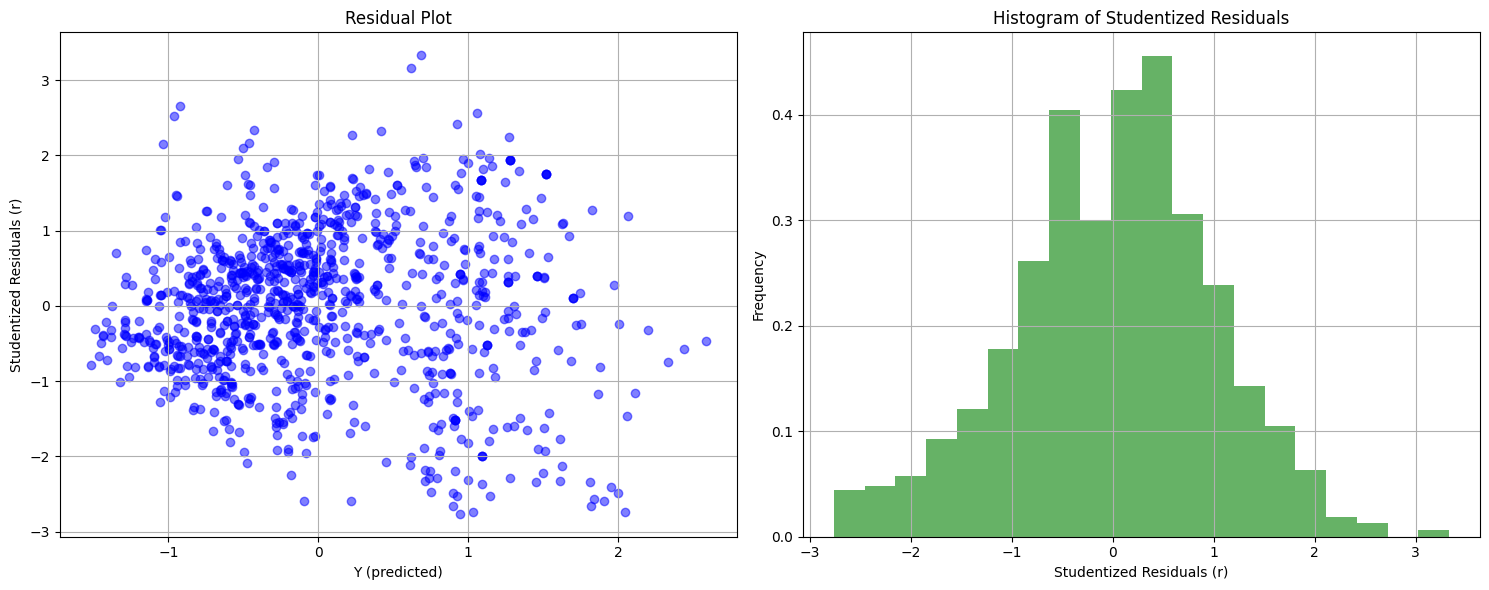



Degree 2 orthogonal polynomial regression started
The Sum of Sqaured Errors for the model ( SSE ) : 232.5395203884522
The Mean Squared error for the model ( MSE ) : 0.22598592846302448
The Sum of Squares Regression for the model ( SSR ) : 797.4604796115478
The Total error for the model ( SST ) :  1030.0
The Model is  significant
Multiple Regression Model Summary:
-----------------------------------------
R-squared            : 0.7742
Adjusted R-squared   : 0.7707
Number of significant terms   : 13
Number of non-significant terms: 4
Model significance   : significant
-----------------------------------------
Chi-square statistic: 3.2729750608367136
P-value: 0.9999781480839348


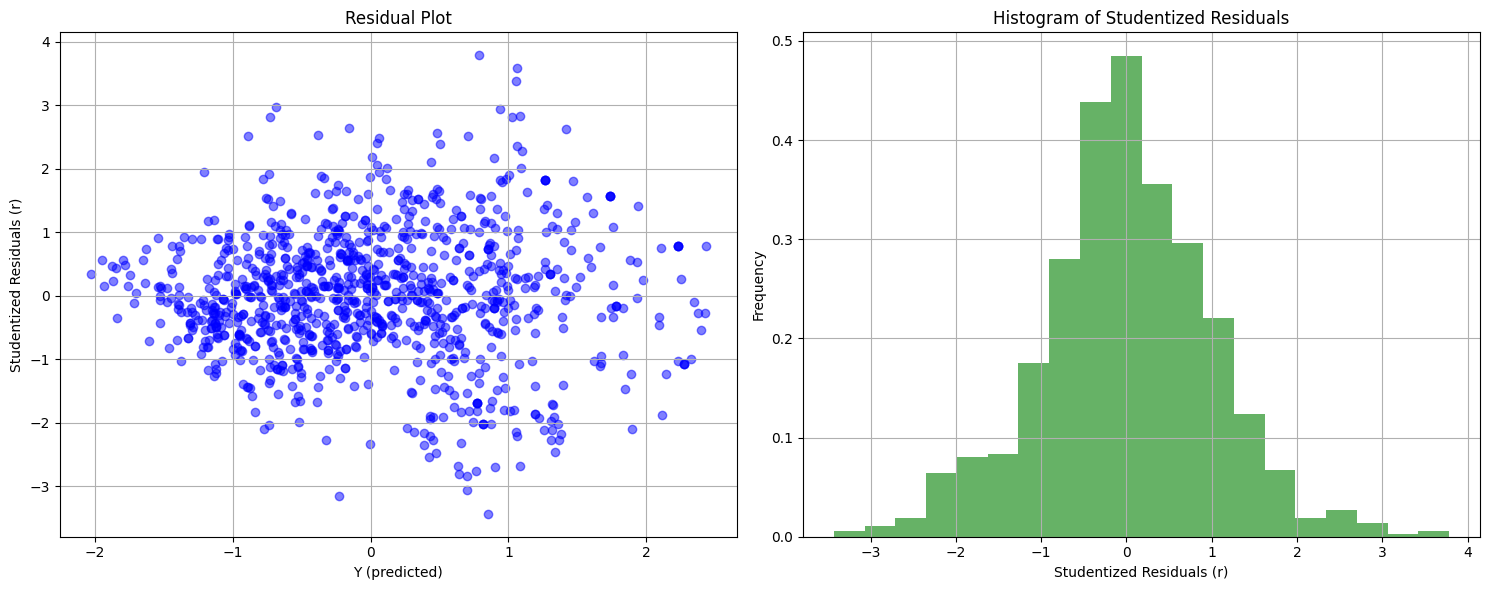



Degree 3 orthogonal polynomial regression started
The Sum of Sqaured Errors for the model ( SSE ) : 164.73741352455346
The Mean Squared error for the model ( MSE ) : 0.1600946681482541
The Sum of Squares Regression for the model ( SSR ) : 865.2625864754466
The Total error for the model ( SST ) :  1030.0
The Model is  significant
Multiple Regression Model Summary:
-----------------------------------------
R-squared            : 0.8401
Adjusted R-squared   : 0.8362
Number of significant terms   : 18
Number of non-significant terms: 7
Model significance   : significant
-----------------------------------------
Chi-square statistic: 3.3308788564490452
P-value: 0.9999748440700084


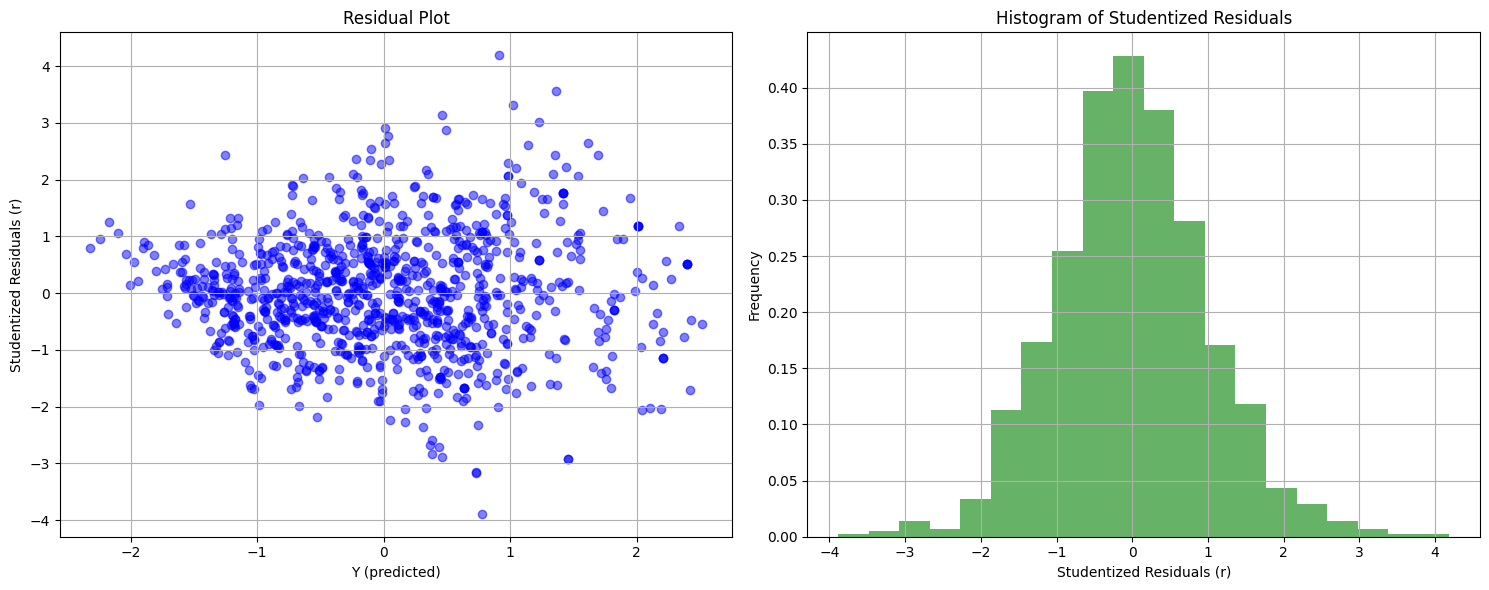



Degree 4 orthogonal polynomial regression started
The Sum of Sqaured Errors for the model ( SSE ) : 132.12062533564142
The Mean Squared error for the model ( MSE ) : 0.12839710916971955
The Sum of Squares Regression for the model ( SSR ) : 897.8793746643586
The Total error for the model ( SST ) :  1030.0
The Model is  significant
Multiple Regression Model Summary:
-----------------------------------------
R-squared            : 0.8717
Adjusted R-squared   : 0.8676
Number of significant terms   : 24
Number of non-significant terms: 9
Model significance   : significant
-----------------------------------------
Chi-square statistic: 3.5736295162419576
P-value: 0.9999559501194862


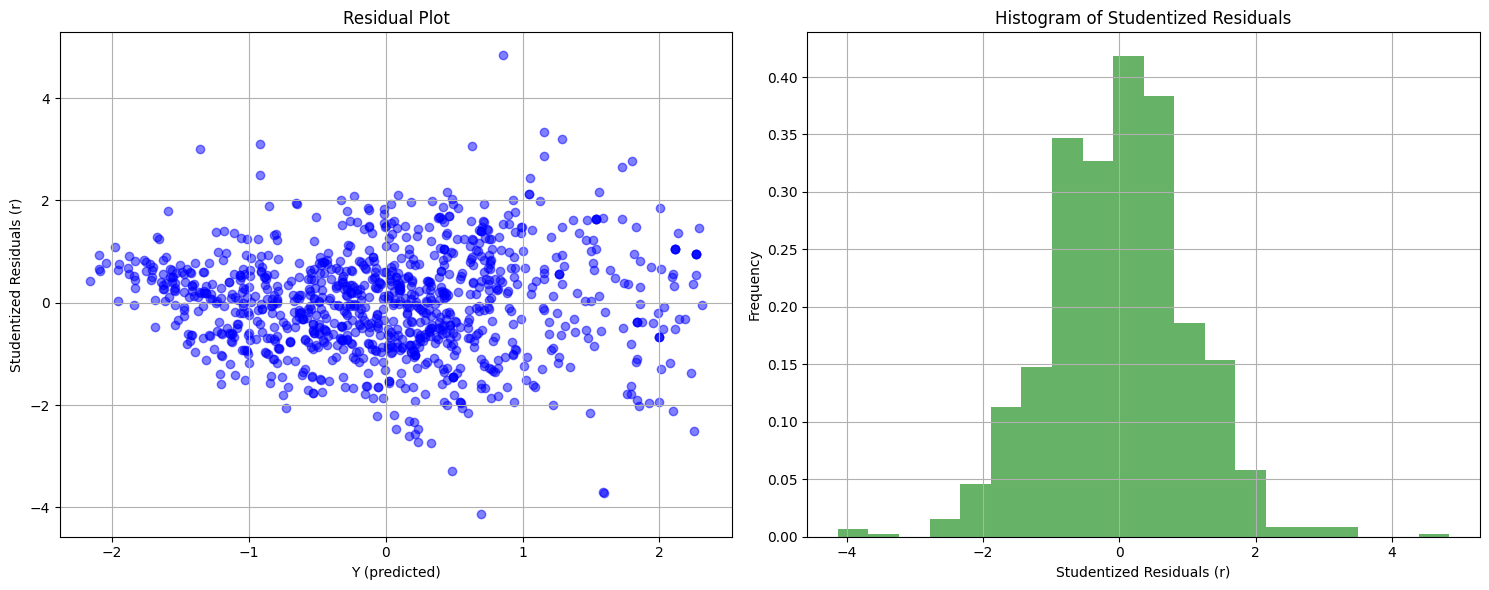



Degree 5 orthogonal polynomial regression started
The Sum of Sqaured Errors for the model ( SSE ) : 125.946129569449
The Mean Squared error for the model ( MSE ) : 0.12239662737555783
The Sum of Squares Regression for the model ( SSR ) : 904.053870430551
The Total error for the model ( SST ) :  1030.0
The Model is  significant
Multiple Regression Model Summary:
-----------------------------------------
R-squared            : 0.8777
Adjusted R-squared   : 0.8728
Number of significant terms   : 28
Number of non-significant terms: 13
Model significance   : significant
-----------------------------------------
Chi-square statistic: 3.396723647707346
P-value: 0.999970578231546


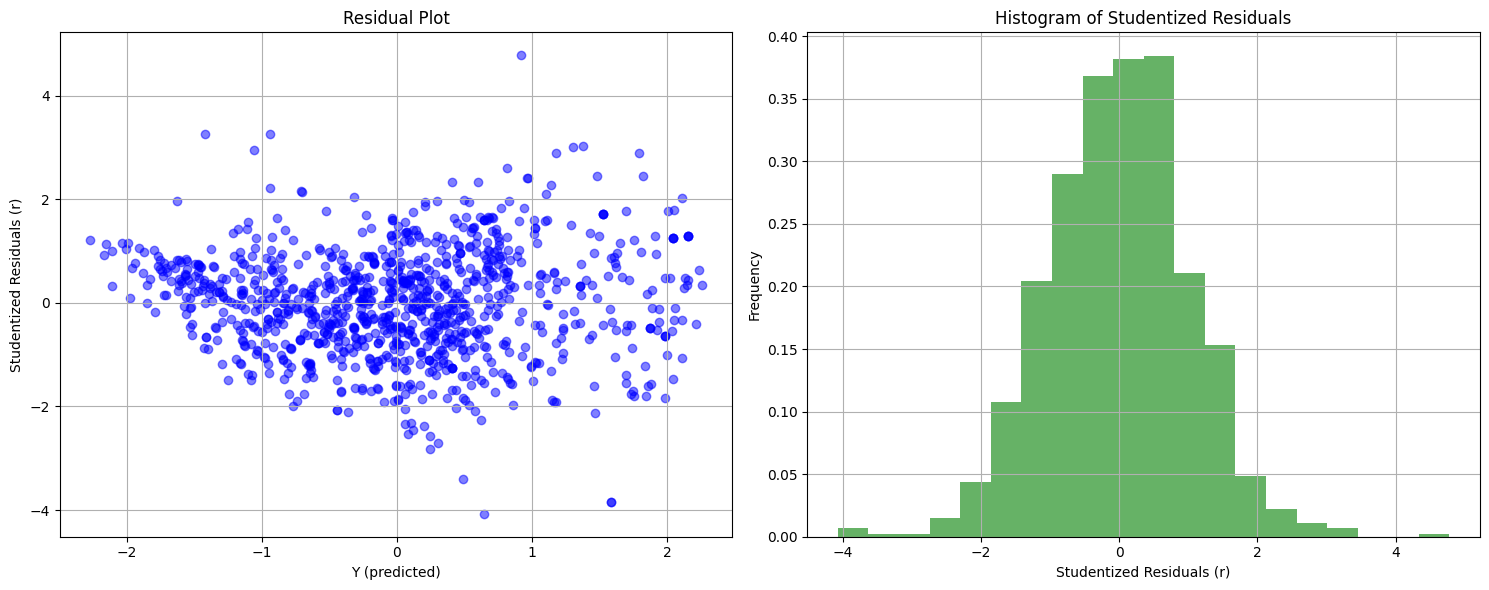

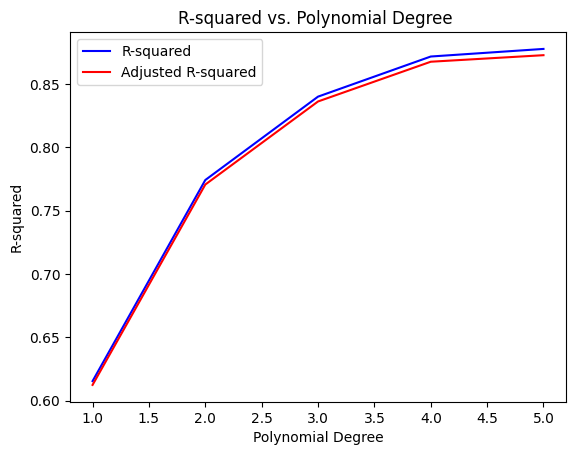

In [20]:
def orthogonal_polynomials(X, degree):
    q = [np.ones(len(X))]
    for i in range(1, degree + 1):
        for j in range(X.shape[1]):
            q_i = X[:, j]**i - np.sum(q_k * np.dot(X[:, j]**i, q_k) / np.dot(q_k, q_k) for q_k in q)
            q.append(q_i)
    return np.array(q).T

def orthogonal_poly_regression(X, y, degree):
    q = orthogonal_polynomials(X, degree)
    beta = np.linalg.lstsq(q, y, rcond=None)[0]
    return q,beta

max_degree = 5
R2 = []
R2_adj = []

for d in range(1,max_degree+1):
  print(f"Degree {d} orthogonal polynomial regression started")
  X_modified,beta = orthogonal_poly_regression(X, Y, d)
  x,y,_ = analyse_model(X_modified,Y,beta,X_test = None, Y_test = None,test_check = False)
  plot_residual(X_modified, Y, beta, X.shape[1]-1)
  R2.append(x)
  R2_adj.append(y)
  print("\n")

import matplotlib.pyplot as plt
plt.plot([d for d in range(1, max_degree + 1)], R2, label='R-squared', color='blue')
plt.plot([d for d in range(1, max_degree + 1)], R2_adj, label='Adjusted R-squared', color='red')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.title('R-squared vs. Polynomial Degree ')
plt.legend()
plt.show()


# LASSO

In [21]:
# from sklearn.linear_model import Lasso

# def fit_upto_degree_lasso(X, Y, degree, alpha=10):
#     poly = PolynomialFeatures(degree)
#     new_X = poly.fit_transform(X)
#     # print(new_X,Y)
#     lasso_model = Lasso(alpha=alpha, fit_intercept = False)
#     lasso_model.fit(new_X, Y)
#     beta = lasso_model.coef_
#     R2, R2_adj,temp = analyse_model(new_X,Y,beta)
#     return R2, R2_adj



In [22]:
# max_degree = 10
# R2 = []
# R2_adj = []
# for d in range(1, max_degree + 1):
#     r2,r2_adj = fit_upto_degree_lasso(X, Y, d)
#     R2.append(r2)
#     R2_adj.append(r2_adj)


# import matplotlib.pyplot as plt
# plt.plot([d for d in range(1, max_degree + 1)], R2, label='R-squared', color='blue')
# plt.plot([d for d in range(1, max_degree + 1)], R2_adj, label='Adjusted R-squared', color='red')
# plt.xlabel('Polynomial Degree')
# plt.ylabel('R-squared')
# plt.title('R-squared vs. Polynomial Degree')
# plt.legend()
# plt.show()

# RIDGE

In [23]:
from sklearn.linear_model import Ridge

def fit_upto_degree_ridge(X, Y, degree, alpha=100):
    poly = PolynomialFeatures(degree)
    new_X = poly.fit_transform(X)

    X_train, X_test, Y_train, Y_test = train_test_split(new_X, Y, test_size=0.2, random_state=42)
    ridge_model = Ridge(alpha=alpha, fit_intercept=False)
    ridge_model.fit(X_train, Y_train)

    beta = ridge_model.coef_
    R2, R2_adj,temp = analyse_model(X_train, Y_train, beta, X_test, Y_test)

    return R2, R2_adj

Degree 1 Ridge regression started
The Sum of Sqaured Errors for the model ( SSE ) : 344.79013502529597
The Mean Squared error for the model ( MSE ) : 0.4189430559238104
The Sum of Squares Regression for the model ( SSR ) : 494.80121290879015
The Total error for the model ( SST ) :  839.5913479340861
The Model is  significant
Multiple Regression Model Summary:
-----------------------------------------
R-squared            : 0.5893
Adjusted R-squared   : 0.5853
Number of significant terms   : 5
Number of non-significant terms: 4
Model significance   : significant
SSE on test set: 75.1199902081647
MSE on test set: 8.346665578684966
-----------------------------------------


Degree 2 Ridge regression started
The Sum of Sqaured Errors for the model ( SSE ) : 215.67440559227094
The Mean Squared error for the model ( MSE ) : 0.2620588160294908
The Sum of Squares Regression for the model ( SSR ) : 623.9169423418152
The Total error for the model ( SST ) :  839.5913479340861
The Model is  signi

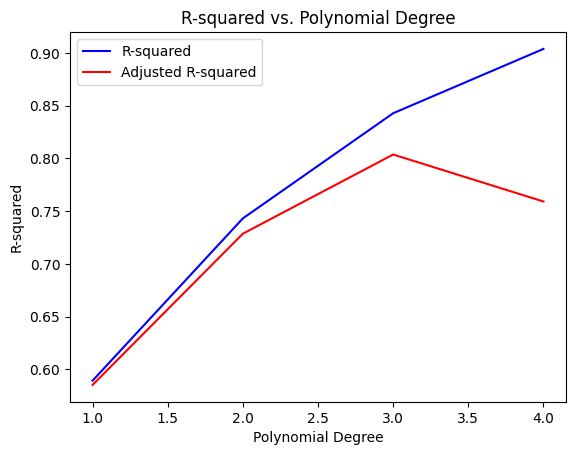

In [24]:
max_degree = 4
R2 = []
R2_adj = []

for d in range(1, max_degree + 1):
    print(f"Degree {d} Ridge regression started")
    r2,r2_adj = fit_upto_degree_ridge(X, Y, d)
    R2.append(r2)
    R2_adj.append(r2_adj)
    print("\n")

import matplotlib.pyplot as plt
plt.plot([d for d in range(1, max_degree + 1)], R2, label='R-squared', color='blue')
plt.plot([d for d in range(1, max_degree + 1)], R2_adj, label='Adjusted R-squared', color='red')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.title('R-squared vs. Polynomial Degree')
plt.legend()
plt.show()